<a href="https://colab.research.google.com/github/Gyanendratiwari98/Pose-Detection-Correction/blob/main/Pose_Detection_%26_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d ujjwalchowdhury/yoga-pose-classification
import zipfile
zip_ref = zipfile.ZipFile('/content/yoga-pose-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/ujjwalchowdhury/yoga-pose-classification
License(s): CC0-1.0
yoga-pose-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


Found 800 images belonging to 5 classes.
Found 197 images belonging to 5 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 581ms/step - accuracy: 0.4385 - loss: 1.3914 - val_accuracy: 0.8477 - val_loss: 0.5383
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.8560 - loss: 0.4491 - val_accuracy: 0.8934 - val_loss: 0.3309
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.8863 - loss: 0.3178 - val_accuracy: 0.9036 - val_loss: 0.2467
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - accuracy: 0.9329 - loss: 0.2622 - val_accuracy: 0.9188 - val_loss: 0.2507
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.9403 - loss: 0.2051 - val_accuracy: 0.9340 - val_loss: 0.2044
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step - accuracy: 0.9567 - loss: 0.1644 - val_accuracy: 0.9442 - val_loss: 0.1510
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.9488 - loss: 0.1604 - val_accuracy: 0.9645 - val_loss: 0.1222
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.9660 - loss: 0.1218 - val_accuracy: 0.944

              precision    recall  f1-score   support

     Downdog       0.13      0.13      0.13        39
     Goddess       0.20      0.23      0.22        39
       Plank       0.21      0.22      0.22        41
        Tree       0.29      0.26      0.27        39
    Warrior2       0.16      0.15      0.16        39

    accuracy                           0.20       197
   macro avg       0.20      0.20      0.20       197
weighted avg       0.20      0.20      0.20       197



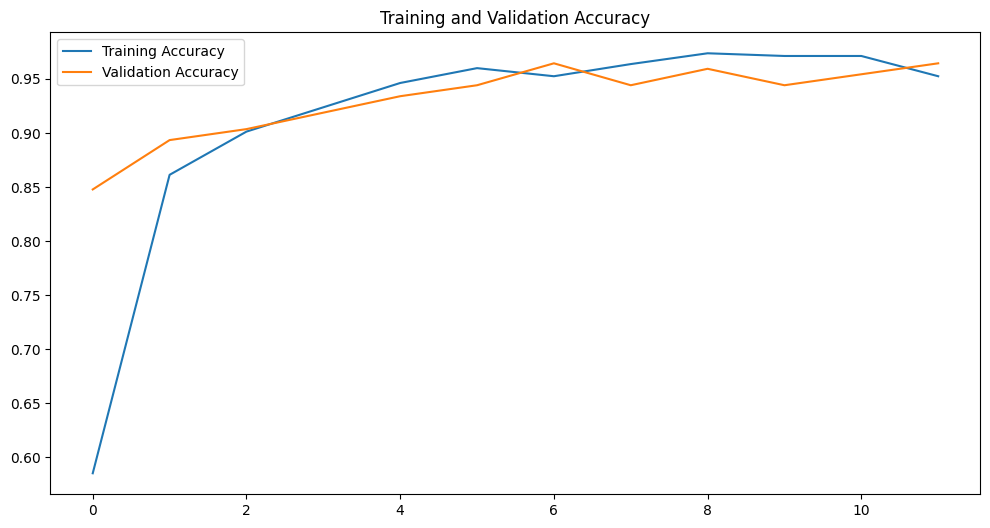

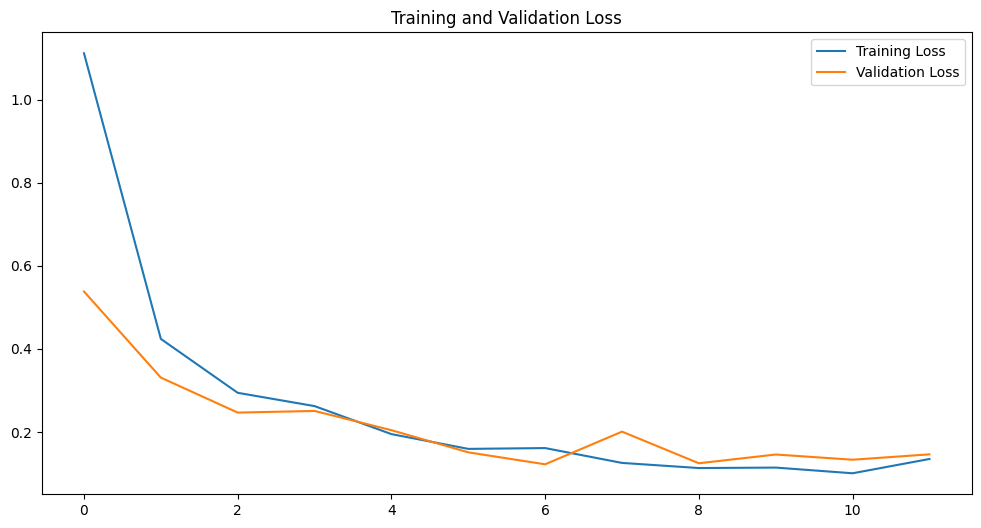

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
import os

# Set paths for the dataset
data_dir = "/content/YogaPoses"  # Replace with your dataset path

# Define parameters
img_size = (224, 224)
batch_size = 32
num_classes = 5  # Update based on the number of yoga poses in your dataset

# Data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Define the model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

# Add custom layers
inputs = Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint = ModelCheckpoint('yoga_pose_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model
print("Evaluating model on validation data...")
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Generate classification report
print("Generating classification report...")
true_classes = validation_generator.classes
class_indices = validation_generator.class_indices
class_labels = list(class_indices.keys())

validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Save the final model
model.save("final_yoga_pose_model.h5")

# Visualize training performance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


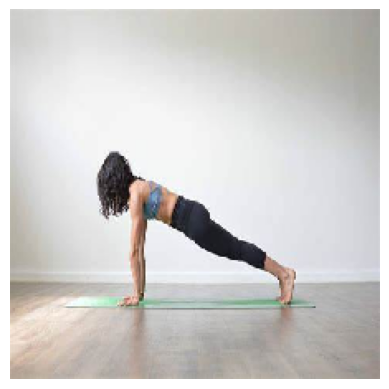

Predicted Class: Class 3 with probability: 0.991835355758667


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model (make sure to use the correct extension .keras or .h5)
model = load_model('yoga_pose_model.keras')  # or 'yoga_pose_model.h5' if you saved as .h5

# Path to the external image you want to test
img_path = '/content/OIP (1).jpg'

# Load the image and preprocess it (resize to 224x224 if the model expects this size)
img = image.load_img(img_path, target_size=(224, 224))  # Change target_size to (224, 224)
img_array = image.img_to_array(img)  # Convert the image to a NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image (same normalization as training)

# Make prediction
pred = model.predict(img_array)

# Show the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the predicted class and its probability
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']  # Replace with your actual class names
predicted_class = np.argmax(pred, axis=1)[0]  # Get the index of the class with the highest probability
predicted_label = class_names[predicted_class]
print(f"Predicted Class: {predicted_label} with probability: {pred[0][predicted_class]}")
